In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
import random
from IPython.display import clear_output
from enum import Enum, auto

2024-02-06 12:36:12.928092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 12:36:12.928141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 12:36:12.928163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
'''
Agent Network: MLP + GRU + MLP + policy
Input: current local state of the environmnent and action of the previous timestep
Output: predicted q-value of the action that the policy selects

Mixing Network: FFn, weights produced by hyper network
Input: agent network outputs
Ouptut: joint q-value

Hyper Network: single linear layer + absolute activation function
Input: global state of the environment (or concatenated local states?)
Output: vector of weights for mixing network
'''

'\nAgent Network: MLP + GRU + MLP + policy\nInput: current local state of the environmnent and action of the previous timestep\nOutput: predicted q-value of the action that the policy selects\n\nMixing Network: FFn, weights produced by hyper network\nInput: agent network outputs\nOuptut: joint q-value\n\nHyper Network: single linear layer + absolute activation function\nInput: global state of the environment (or concatenated local states?)\nOutput: vector of weights for mixing network\n'

In [3]:
class Actions(Enum):
    NO_OP = 0
    MOVE_UP = auto()
    MOVE_DOWN = auto()
    MOVE_LEFT = auto()
    MOVE_RIGHT = auto()
    
    @property
    def delta(self):
        if self == self.NO_OP:
            return (0, 0)
        if self == self.MOVE_UP:
            return (-1, 0)
        if self == self.MOVE_DOWN:
            return (1, 0)
        if self == self.MOVE_LEFT:
            return (0, -1)
        if self == self.MOVE_RIGHT:
            return (0, 1)

    @property 
    def shape(self):
        return len(Actions)

    @property 
    def one_hot(self):
        return tf.one_hot(self.value, len(Actions))

In [6]:
class GridEnv():
    def __init__(self, rows, cols, num_agents):
        self.rows = rows
        self.cols = cols
        
        self.num_agents = num_agents
        self.agent_list = []
        
        self.goal = []
        self.block = []

    def qmix(self):
        agent_inputs = [agent.local_model.inputs for agent in self.agent_list]
        agent_outputs = [agent.local_model.output for agent in self.agent_list]
        global_state = tf.keras.layers.Input(batch_shape=(1, *np.shape(self.get_global_state())))

        q_values = tf.keras.layers.Concatenate()(agent_outputs)
        y = MixingLayer(grid)((q_values, global_state))
        qmix = tf.keras.Model((agent_inputs, global_state), (agent_outputs, y))
        qmix.compile(run_eagerly=True)
        
        return qmix

    def populate_grid(self):
        positions = np.random.choice(self.rows*self.cols, self.num_agents+2, replace=False)

        self.goal = (positions[0]//self.cols, positions[0]%self.cols)
        self.block = (positions[1]//self.cols, positions[1]%self.cols)

        for i in range(self.num_agents):
            agent = Agent(self, i)
            agent.position = (positions[i+2]//self.cols, positions[i+2]%self.cols)
            self.agent_list.append(agent)

    def get_global_state(self):
        return tf.one_hot([p[0]*self.cols+p[1] for p in (self.goal, self.block, *[a.position for a in self.agent_list])], self.rows*self.cols)
    
    def vizualize_grid(self): 
        grid = [list("."*self.cols) for _ in range(self.rows)]

        grid[self.goal[0]][self.goal[1]] = "G"
        grid[self.block[0]][self.block[1]]= "B"

        for i, agent in enumerate(self.agent_list):
            grid[agent.position[0]][agent.position[1]] = str(i)

        return '\n'.join([' '.join(row) for row in grid])

    def __repr__(self):
        return str(self.vizualize_grid())

In [7]:
class Agent():
    def __init__(self, grid, id):
        self.grid = grid

        self.id = id
        self.position = [0, 0]
        self.epsilon = 0.1
        self.gamma = 0.1
        self.alpha = 0.1
        
        self.local_model = self._build_local_model() 

        self.history = ([], [])
        self.previous_action = Actions.NO_OP

    def get_local_state(self):
        return self.grid.get_global_state()

    def take_action(self, action):
        future_position = self.position
        future_position += np.array(action.delta)
        future_position %= [self.grid.rows, self.grid.cols]

        if list(future_position) not in [a.position for a in self.grid.agent_list]:
            if list(future_position) == self.grid.block:
                self.grid.block += np.array(action.delta)
                self.grid.block %= [self.grid.rows, self.grid.cols]
            else:
                self.position = future_position
            
    def get_reward(self):
        if self.grid.block == self.grid.goal:
            return 0
        else:
            return -1

    def get_correct_qvalue(self, pred_max_value, reward, current_max_value):
        q_value = pred_max_value + self.alpha * (reward + self.gamma * current_max_value - pred_max_value)
        return q_value
                
    def _build_local_model(self):
        local_state = tf.keras.layers.Input(batch_shape=(1, None, self.grid.num_agents+2, self.grid.rows * self.grid.cols), name=f"Local_State{self.id}") #Input: local state
        prev_action = tf.keras.layers.Input(batch_shape=(1, None, len(Actions)), name=f"Prev_Action{self.id}") #Input: previous action
        y = tf.keras.layers.Reshape((-1, (self.grid.num_agents+2) * self.grid.rows * self.grid.cols))(local_state)
        y = tf.keras.layers.Concatenate(axis=-1)([y, prev_action])
        y = tf.keras.layers.Dense(64, activation="relu")(y)
        y = tf.keras.layers.GRU(64, stateful=False)(y)
        y = tf.keras.layers.Dense(len(Actions))(y) #Output: q value of actions

        model = tf.keras.Model((local_state, prev_action), y) # outputs hidden state tensor->pass back in as input return_state=true
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.Huber())
        
        return model
    
    def step(self):
        current_state = self.get_local_state()

        self.history[0].append(current_state)
        self.history[1].append(self.previous_action.one_hot)
        
        pred_qvalues = self.local_model((np.array([self.history[0]]), np.array([self.history[1]])))[0].numpy() #placeholder action
        pred_max_index = np.argmax(pred_qvalues)

        if random.random() < self.epsilon:
           action = random.choice(list(Actions))
        else:
            action = Actions(pred_max_index)
            
        self.take_action(action)
        self.previous_action = action
        future_state = self.get_local_state()
        
        reward = self.get_reward()
        
        future_qvalues  = self.local_model((np.array([self.history[0]+[future_state]]), np.array([self.history[1]+[action.one_hot]])))[0].numpy()
        future_max_index = np.argmax(future_qvalues)

        target_qvalue = self.get_correct_qvalue(pred_qvalues[pred_max_index], reward, future_qvalues[future_max_index])
        target_qvalues = pred_qvalues.copy()
        target_qvalues[pred_max_index] = target_qvalue

        self.grid.q_values[self.id] = target_qvalue

        self.local_model.fit((np.array([self.history[0]]), np.array([self.history[1]])), np.array([target_qvalues]), verbose=0) 

In [15]:
class MixingLayer(tf.keras.layers.Layer):
    def __init__(self, grid, **kwargs):
        super().__init__(**kwargs)
        self.grid = grid
        
        self.hyper_w1 = tf.keras.layers.Dense(grid.num_agents*64, use_bias=False) 
        self.hyper_b1 = tf.keras.layers.Dense(64, use_bias=False)
        
        self.hyper_w2 = tf.keras.layers.Dense(64, use_bias=False)
        self.hyper_b2 = tf.keras.layers.Dense(64, use_bias=False)
        self.hyper_b2_final = tf.keras.layers.Dense(1, use_bias=False)

    def call(self, inputs):
        q_values = tf.transpose(tf.reshape(inputs[0], (1, self.grid.num_agents, -1)), (0, 2, 1))
        state_dim = inputs[0].shape[-1]
        global_state = tf.reshape(inputs[1], (1, -1))

        w1 = self.hyper_w1(global_state) # take in global state to produce 1st layer weights
        w1 = tf.math.abs(w1) # take absolute value
        w1 = tf.reshape(w1, (1, grid.num_agents, 64))
        b1 = self.hyper_b1(global_state) # add the bias

        output_w1 = tf.keras.activations.elu(tf.matmul(q_values, w1) + b1)
        
        w2 = self.hyper_w2(global_state)
        w2 = tf.math.abs(w2)
        b2 = tf.keras.activations.relu(self.hyper_b2(global_state))
        b2 = self.hyper_b2_final(b2)
        
        joint_q = tf.matmul(output_w1, w2, transpose_b=True) + b2
        joint_q = tf.reshape(joint_q, (1, -1))
        return joint_q

In [16]:
rows = 6
cols = 6
num_agents = 2

grid = GridEnv(rows, cols, num_agents)
grid.populate_grid()

In [17]:
qmix = grid.qmix()

In [18]:
global_state = grid.get_global_state()
agent_states = []
for agent in grid.agent_list:
    agent_states.append(np.array([[agent.get_local_state()]]))
    agent_states.append(np.array([[agent.previous_action.one_hot]]))

In [19]:
q_values, q_total = qmix((agent_states, global_state))

In [20]:
q_values

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.04115395,  0.01069353, -0.12157153, -0.06689923, -0.048053  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.08692273, -0.01236806,  0.06583862,  0.11931928, -0.08930182]],
       dtype=float32)>]

In [14]:
q_total

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.20042777,  0.31174427,  0.09408337, -0.03500295,  0.15938163]],
      dtype=float32)>

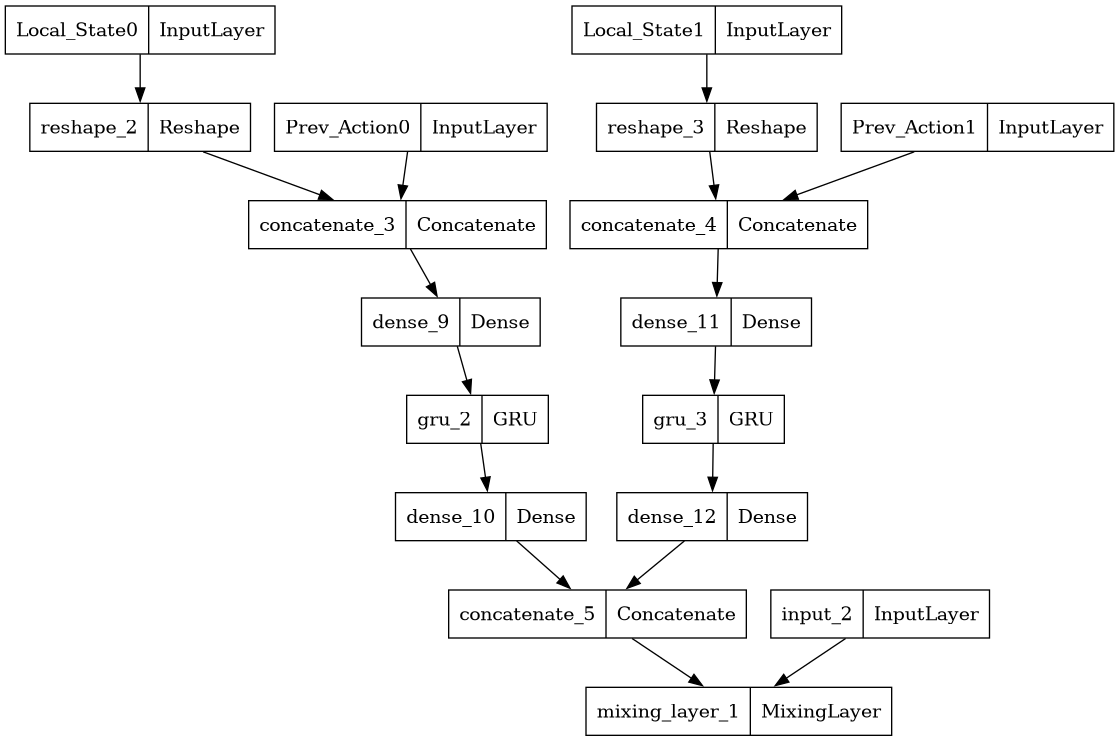

In [21]:
tf.keras.utils.plot_model(qmix)